In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F

import copy


# ===================================
FRAC = 0.1  
# ===================================



# plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 7)})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes


        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        z = self.feature_extractor(x)
        p = self.classifier(z)
        return p

    def feature_extractor(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        x = self.adaptive_pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)

        return x

    def classifier(self, features):
        return self.fc3(features)

def dirichlet_partition(dataset, num_clients, alpha, num_classes=10):
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    client_indices = [[] for _ in range(num_clients)]

    # Keep a matrix: client × class → #samples
    class_counts = np.zeros((num_clients, num_classes), dtype=int)

    for k in range(num_classes):
        idx_k = np.where(labels == k)[0]
        np.random.shuffle(idx_k)

        # === MODIFIED: Only use FRAC fraction of samples per class ===
        num_samples = int(len(idx_k) * FRAC)
        idx_k = idx_k[:num_samples]
        # ==========================================================

        if len(idx_k) == 0:
            continue  # Skip if no samples after sampling

        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        client_splits = np.split(idx_k, proportions)
        for client_idx, split in enumerate(client_splits):
            client_indices[client_idx].extend(split)
            class_counts[client_idx, k] = len(split)   # <-- count per class

    # --------------------------------------------------------------
    # NEW: Print label distribution per client
    # --------------------------------------------------------------
    print("\nLabel distribution (samples per class) for each client:")
    print("Client → Class 0 1 2 3 4 5 6 7 8 9  |  Total")
    print("-" * 55)
    for c in range(num_clients):
        totals = class_counts[c].sum()
        row = f"  {c+1:2d}  → " + " ".join(f"{v:2d}" for v in class_counts[c]) + f"  | {totals:4d}"
        print(row)
    print("-" * 55)
    # --------------------------------------------------------------

    for i in range(num_clients):
        np.random.shuffle(client_indices[i])

    return client_indices

# === Rest of your functions unchanged ===
def compute_label_distribution(dataset, client_indices, num_classes=10):
    distributions = []
    for indices in client_indices:
        if len(indices) == 0:
            distributions.append(np.zeros(num_classes))
            continue
        labels = [dataset[i][1] for i in indices]
        label_counts = np.bincount(labels, minlength=num_classes)
        distributions.append(label_counts / len(indices))
    return np.array(distributions)

def compute_kl_divergence(p, q):
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    return np.sum(p * np.log(p / q))

def compute_js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * compute_kl_divergence(p, m) + 0.5 * compute_kl_divergence(q, m)


def train_client(model, dataloader, epochs, lr):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for epoch in range(epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Skip single-sample batches to avoid BatchNorm issues
            if inputs.size(0) == 1:
                continue

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / (len(dataloader) * epochs) if len(dataloader) > 0 else 0
    accuracy = 100. * total_correct / total_samples if total_samples > 0 else 0

    return model.state_dict(), avg_loss, accuracy


def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    accuracy = 100. * correct / total if total > 0 else 0
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0
    return accuracy, avg_loss

def aggregate_models(global_model, client_models, client_weights):
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        global_dict[key] = torch.zeros_like(global_dict[key], dtype=torch.float32)
        for client_model, weight in zip(client_models, client_weights):
            global_dict[key] += client_model[key].float() * weight

    global_model.load_state_dict(global_dict)
    return global_model

def compute_model_divergence(model1_dict, model2_dict):
    divergence = 0.0
    total_params = 0

    for key in model1_dict.keys():
        if 'weight' in key or 'bias' in key:
            diff = model1_dict[key].float() - model2_dict[key].float()
            divergence += torch.sum(diff ** 2).item()
            total_params += diff.numel()

    return np.sqrt(divergence / total_params) if total_params > 0 else 0

def federated_learning(num_clients, num_rounds, local_epochs, lr, alpha, batch_size=64):
    print(f'\n{"="*60}')
    print(f'Training with α = {alpha}')
    print(f'{"="*60}')

    client_indices = dirichlet_partition(trainset, num_clients, alpha)
    label_distributions = compute_label_distribution(trainset, client_indices)

    global_model = SimpleCNN().to(device)
    initial_state = copy.deepcopy(global_model.state_dict())

    metrics = {
        'test_accuracy': [],
        'test_loss': [],
        'train_accuracy': [],
        'train_loss': [],
        'client_divergences': [],
        'client_train_acc': [[] for _ in range(num_clients)],
        'weight_norms': [],
        'gradient_diversity': []
    }

    for round_num in range(num_rounds):
        client_models = []
        client_weights = []
        client_train_losses = []
        client_train_accs = []
        round_divergences = []

        global_state_before = copy.deepcopy(global_model.state_dict())

        for client_idx in range(num_clients):
            client_model = SimpleCNN().to(device)
            client_model.load_state_dict(copy.deepcopy(global_model.state_dict()))

            client_dataset = Subset(trainset, client_indices[client_idx])
            if len(client_dataset) == 0:
                continue  # Skip empty clients

            # Adjust batch size to avoid single-sample batches
            effective_batch_size = min(batch_size, max(2, len(client_dataset) // 2))
            client_loader = DataLoader(client_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=2)

            client_state, train_loss, train_acc = train_client(client_model, client_loader, local_epochs, lr)

            divergence = compute_model_divergence(client_state, global_state_before)
            round_divergences.append(divergence)

            client_models.append(client_state)
            client_weights.append(len(client_indices[client_idx]))
            client_train_losses.append(train_loss)
            client_train_accs.append(train_acc)
            metrics['client_train_acc'][client_idx].append(train_acc)

        if len(client_weights) == 0 or sum(client_weights) == 0:
            print(f"Warning: No clients participated in round {round_num+1}")
            continue

        total_samples = sum(client_weights)
        client_weights = [w / total_samples for w in client_weights]

        global_model = aggregate_models(global_model, client_models, client_weights)

        test_acc, test_loss = evaluate_model(global_model, testloader)
        avg_train_acc = np.mean(client_train_accs) if client_train_accs else 0
        avg_train_loss = np.mean(client_train_losses) if client_train_losses else 0

        metrics['test_accuracy'].append(test_acc)
        metrics['test_loss'].append(test_loss)
        metrics['train_accuracy'].append(avg_train_acc)
        metrics['train_loss'].append(avg_train_loss)
        metrics['client_divergences'].append(np.mean(round_divergences) if round_divergences else 0)

        weight_norm = sum([torch.norm(p).item() ** 2 for p in global_model.parameters()]) ** 0.5
        metrics['weight_norms'].append(weight_norm)

        pairwise_divergences = []
        for i in range(len(client_models)):
            for j in range(i + 1, len(client_models)):
                div = compute_model_divergence(client_models[i], client_models[j])
                pairwise_divergences.append(div)
        metrics['gradient_diversity'].append(np.mean(pairwise_divergences) if pairwise_divergences else 0)

        if (round_num + 1) % 10 == 0:
            print(f'Round {round_num+1}/{num_rounds} | Test Acc: {test_acc:.2f}% | '
                  f'Train Acc: {avg_train_acc:.2f}% | Client Div: {np.mean(round_divergences):.4f}')

    return metrics, label_distributions

# === Fixed training loop with error handling ===
num_clients = 10
num_rounds = 50
local_epochs = 5
learning_rate = 0.01
batch_size = 64
alphas = [0.05, 0.1, 0.5, 1.0, 100.0]
all_results = {}
all_distributions = {}
np.random.seed(42)
torch.manual_seed(42)

for alpha in alphas:
    try:
        metrics, distributions = federated_learning(num_clients, num_rounds, local_epochs, learning_rate, alpha, batch_size)
        all_results[alpha] = metrics
        all_distributions[alpha] = distributions
        print(f"Done training for α = {alpha}")
    except Exception as e:
        print(f"Error training for α = {alpha}: {e}")
        continue


Using device: cuda

Training with α = 0.05

Label distribution (samples per class) for each client:
Client → Class 0 1 2 3 4 5 6 7 8 9  |  Total
-------------------------------------------------------
   1  →  0  0 359  0  0  0  0  0 71 365  |  795
   2  →  0  0 17  0 495  0 85  0 208  0  |  805
   3  →  0  2  1  0  4  0  1  0  0  4  |   12
   4  → 84  1 110  0  0  0  0  0  0  1  |  196
   5  → 415  0  0  0  0 30  0  0  0  0  |  445
   6  →  0  0  0  0  0  0  0  0 220  0  |  220
   7  →  0  0  1  0  0 437 324 499  0 52  | 1313
   8  →  0 460  0 499  0  0  0  0  0  0  |  959
   9  →  0 36  0  1  0 13  0  0  0 78  |  128
  10  →  1  1 12  0  1 20 90  1  1  0  |  127
-------------------------------------------------------
Round 10/50 | Test Acc: 29.35% | Train Acc: 82.78% | Client Div: 0.0041
Round 20/50 | Test Acc: 23.30% | Train Acc: 83.61% | Client Div: 0.0044
Round 30/50 | Test Acc: 36.64% | Train Acc: 85.88% | Client Div: 0.0039
Round 40/50 | Test Acc: 36.59% | Train Acc: 85.55% | Cl

Successfully trained alphas: [0.05, 0.1, 0.5, 1.0, 100.0]


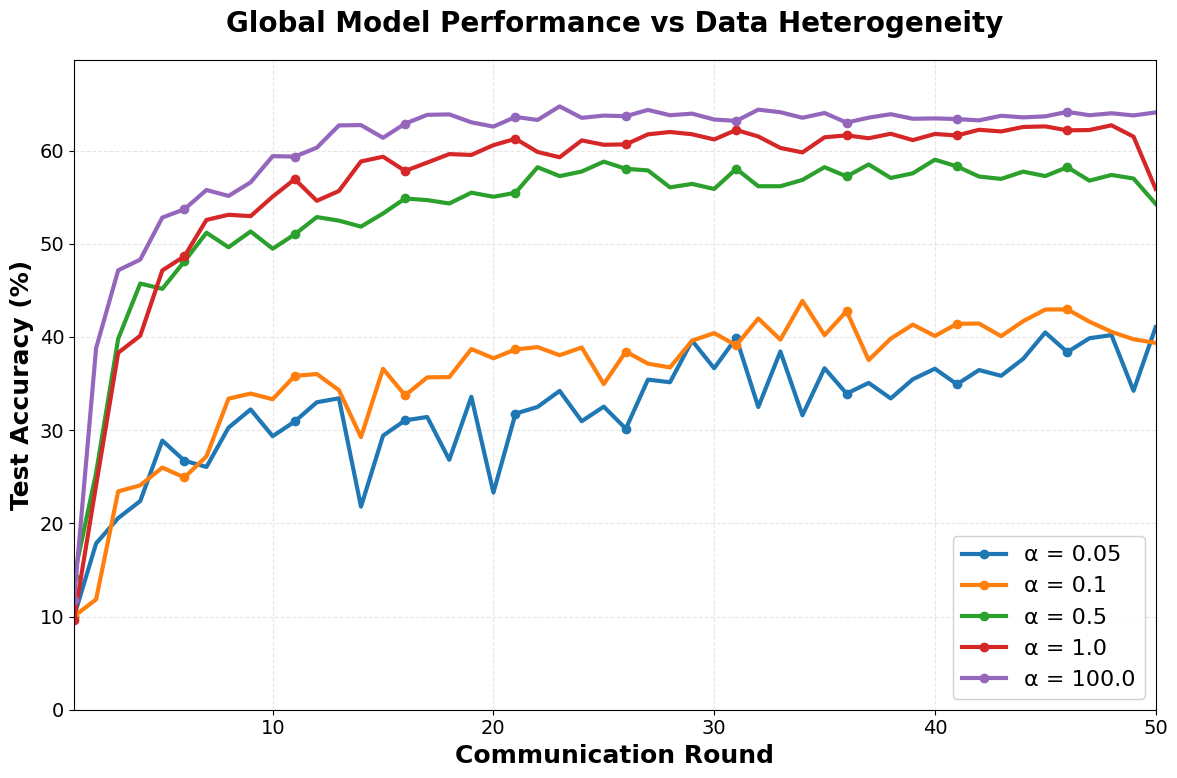

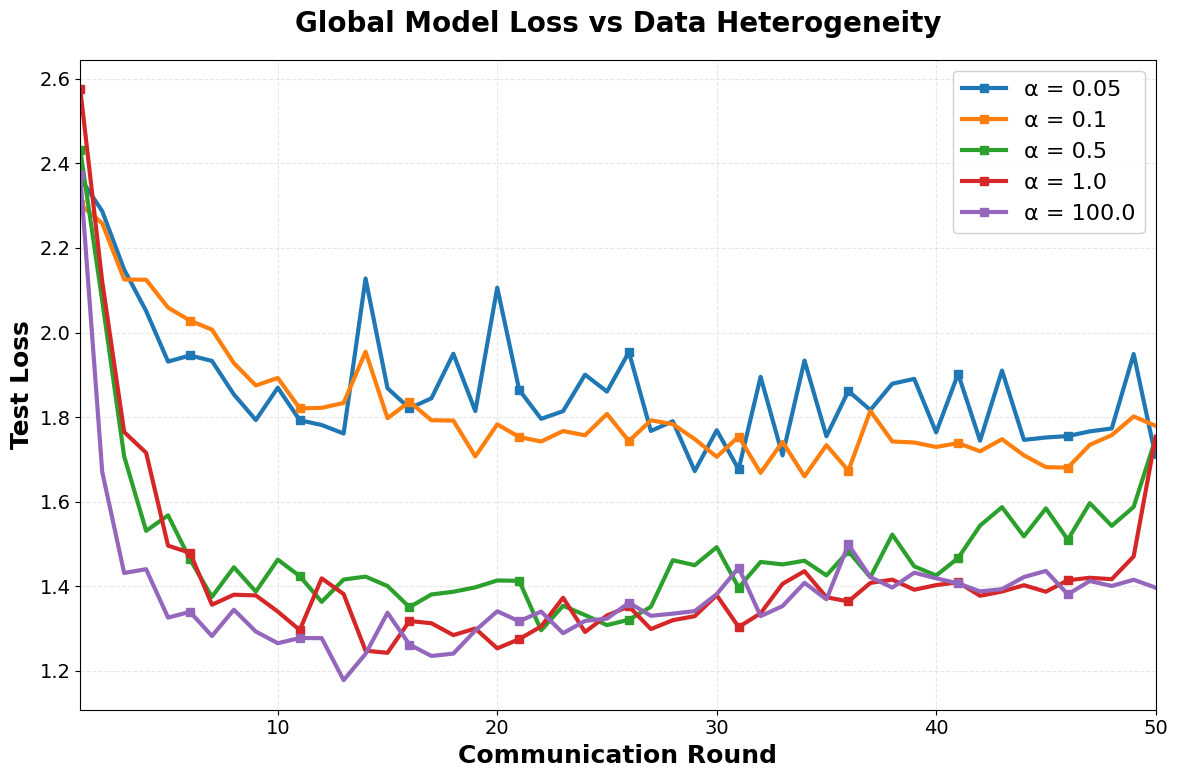

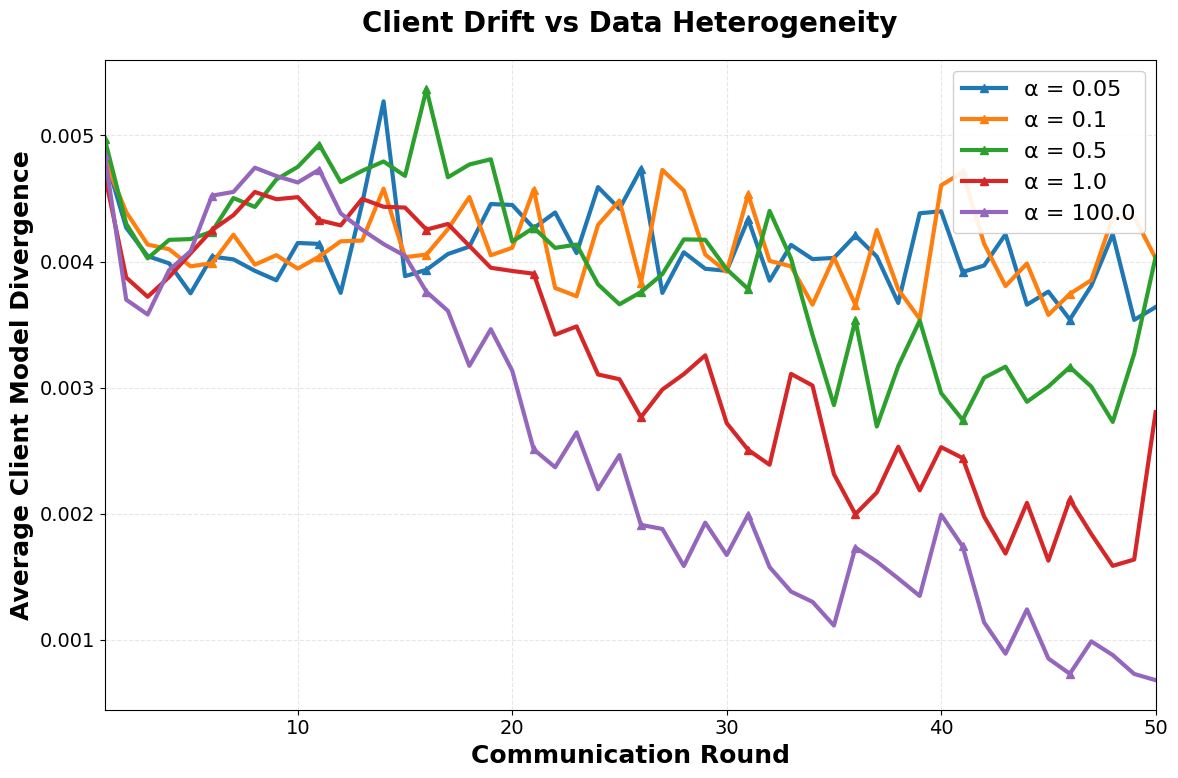

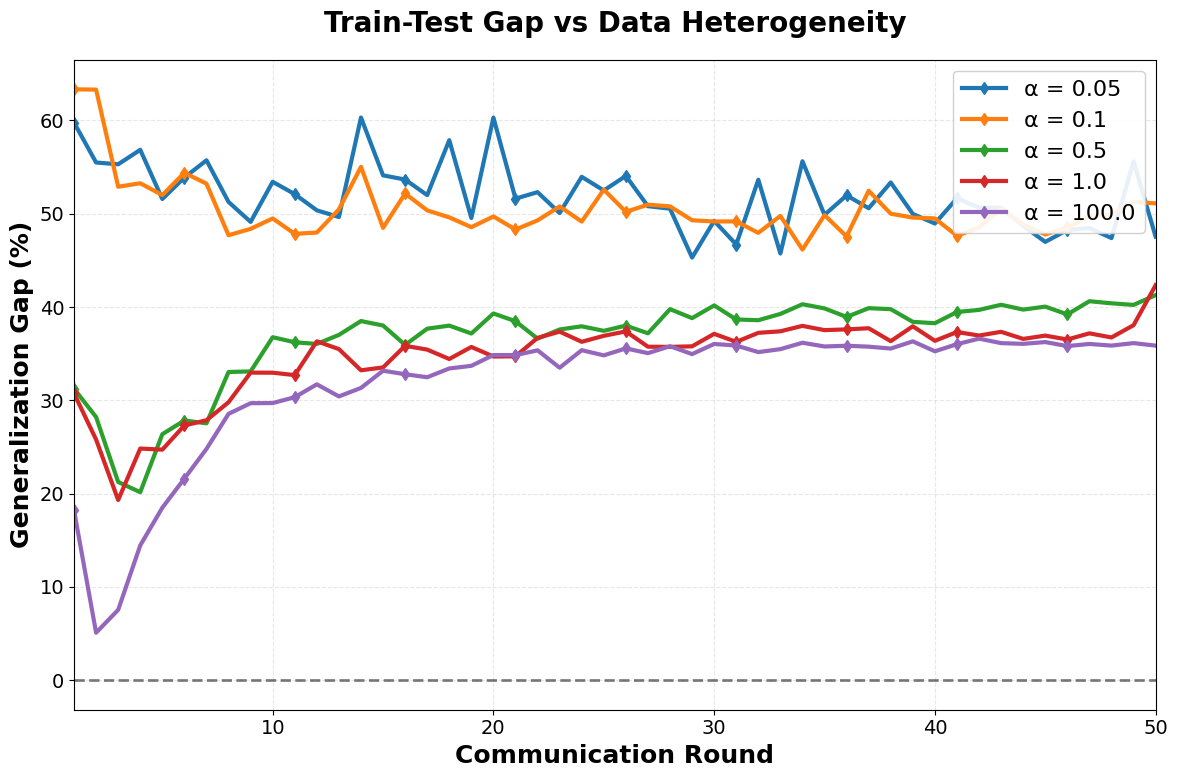

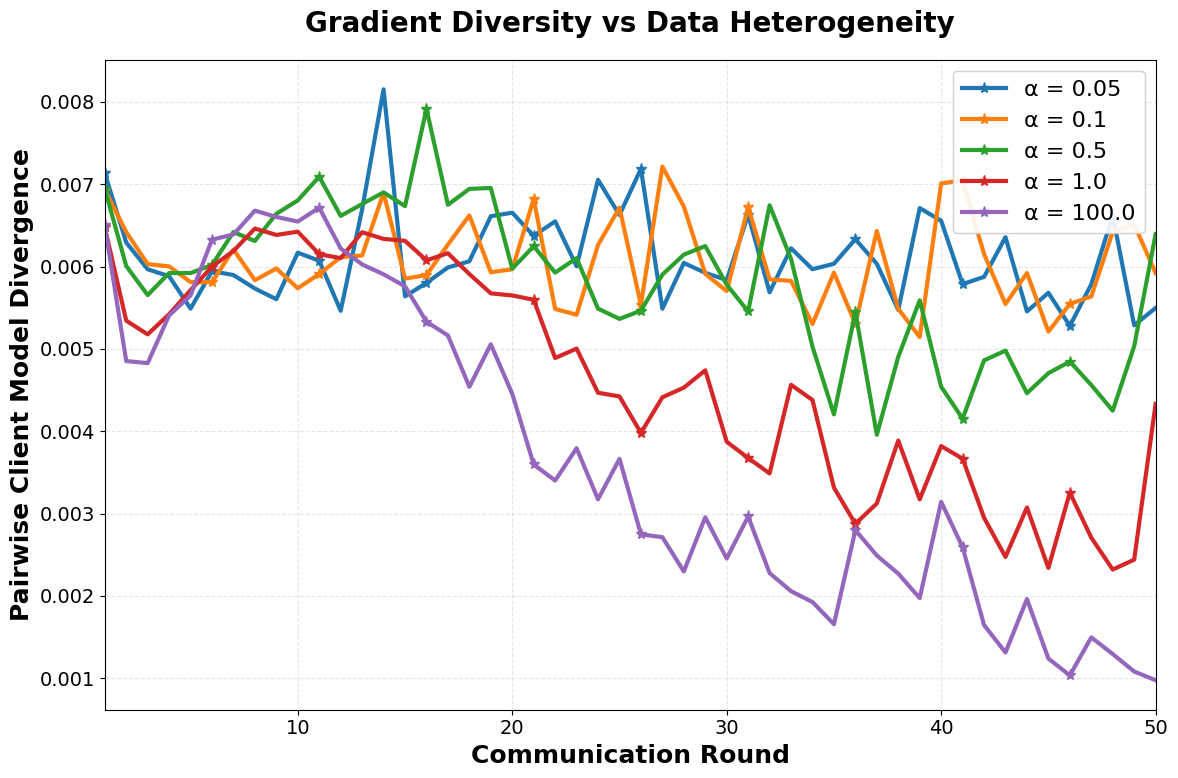

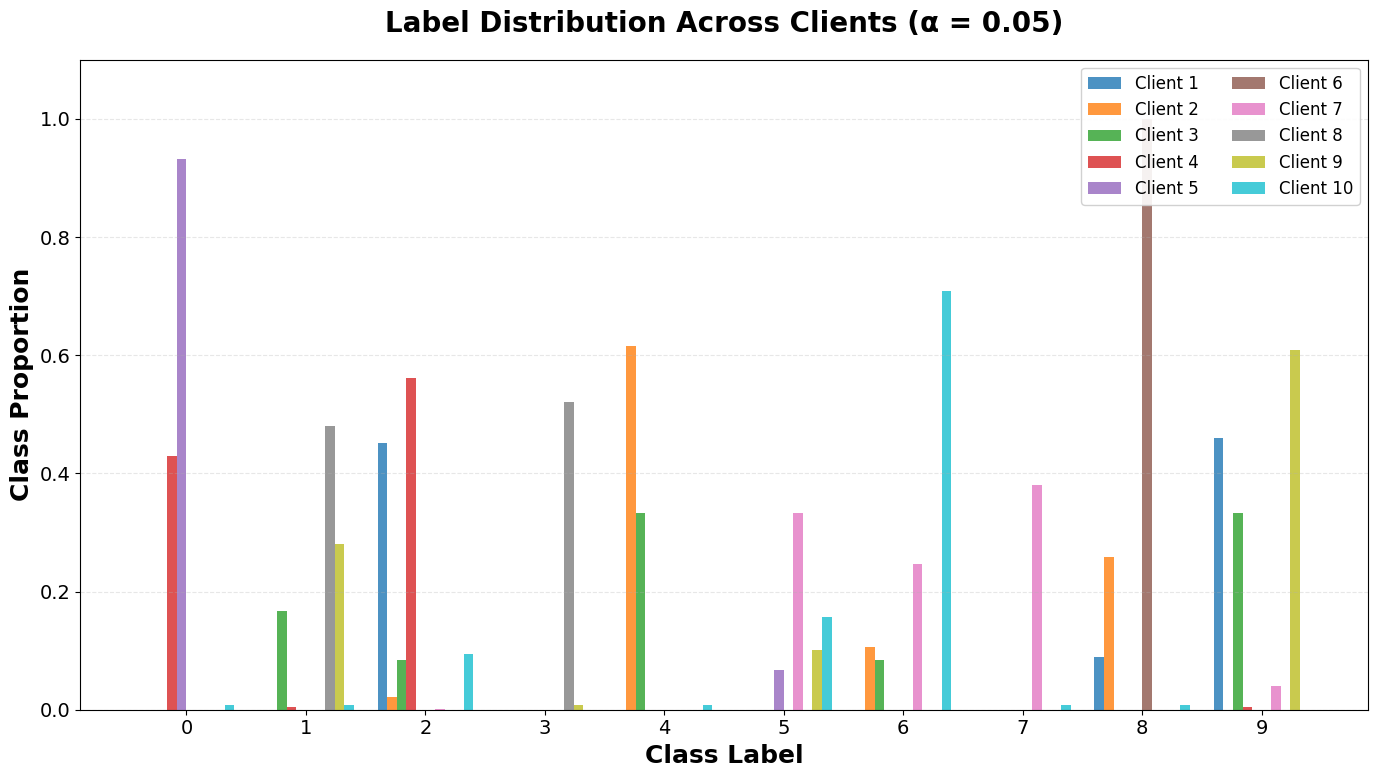

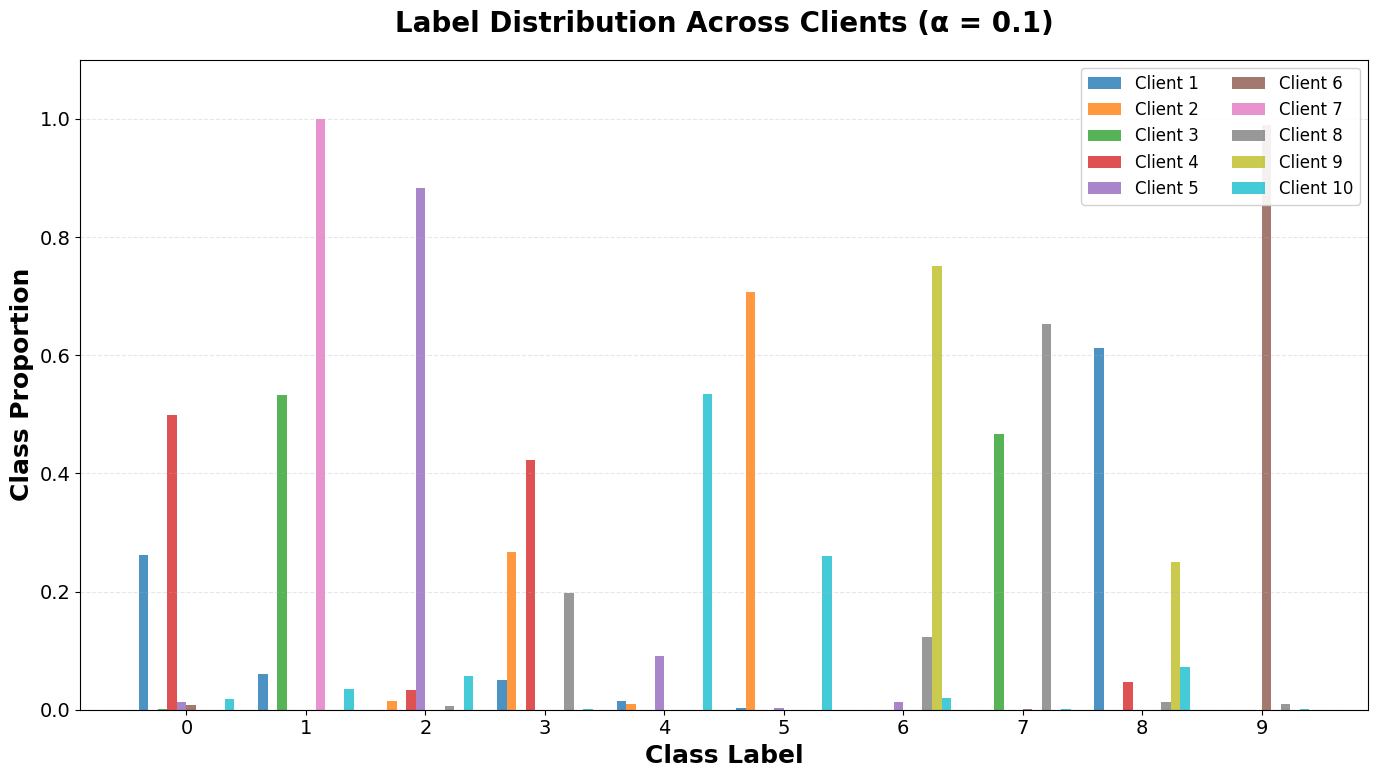

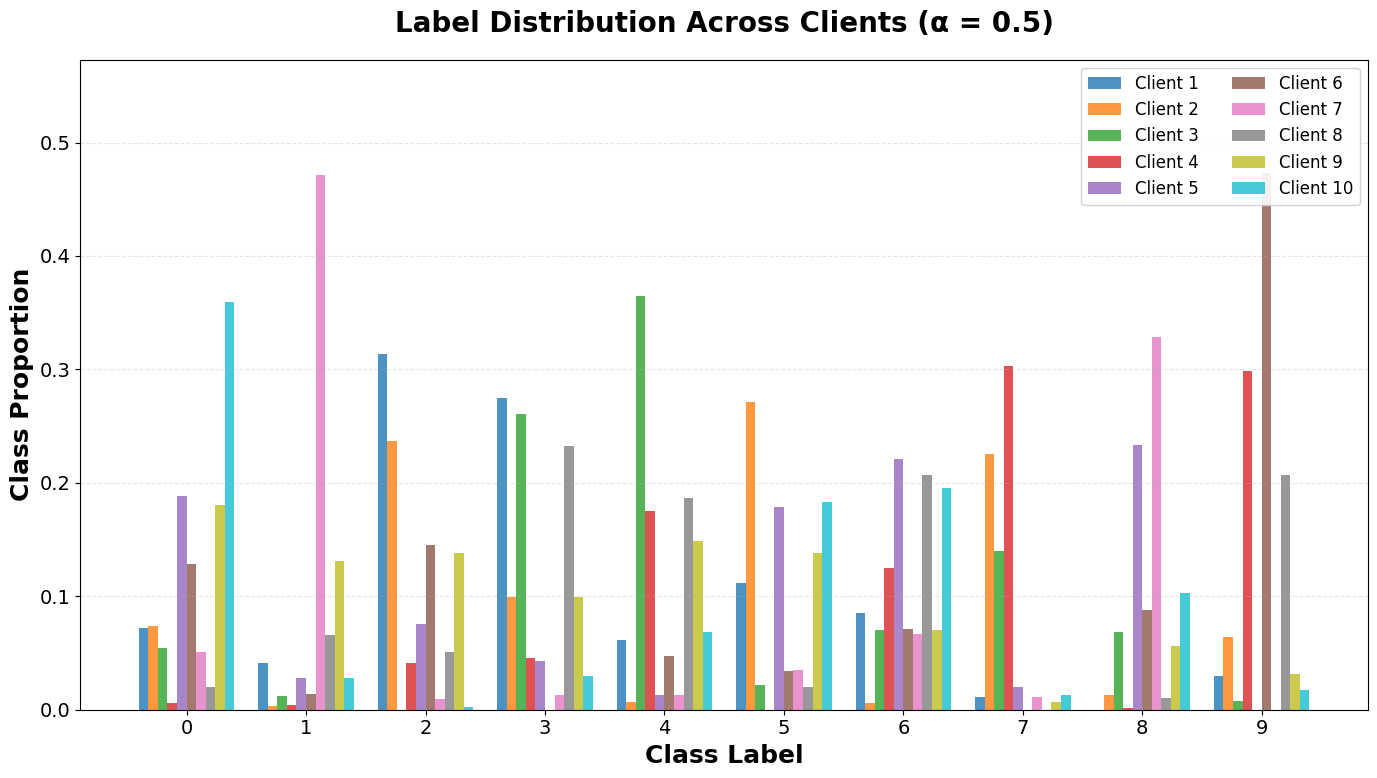

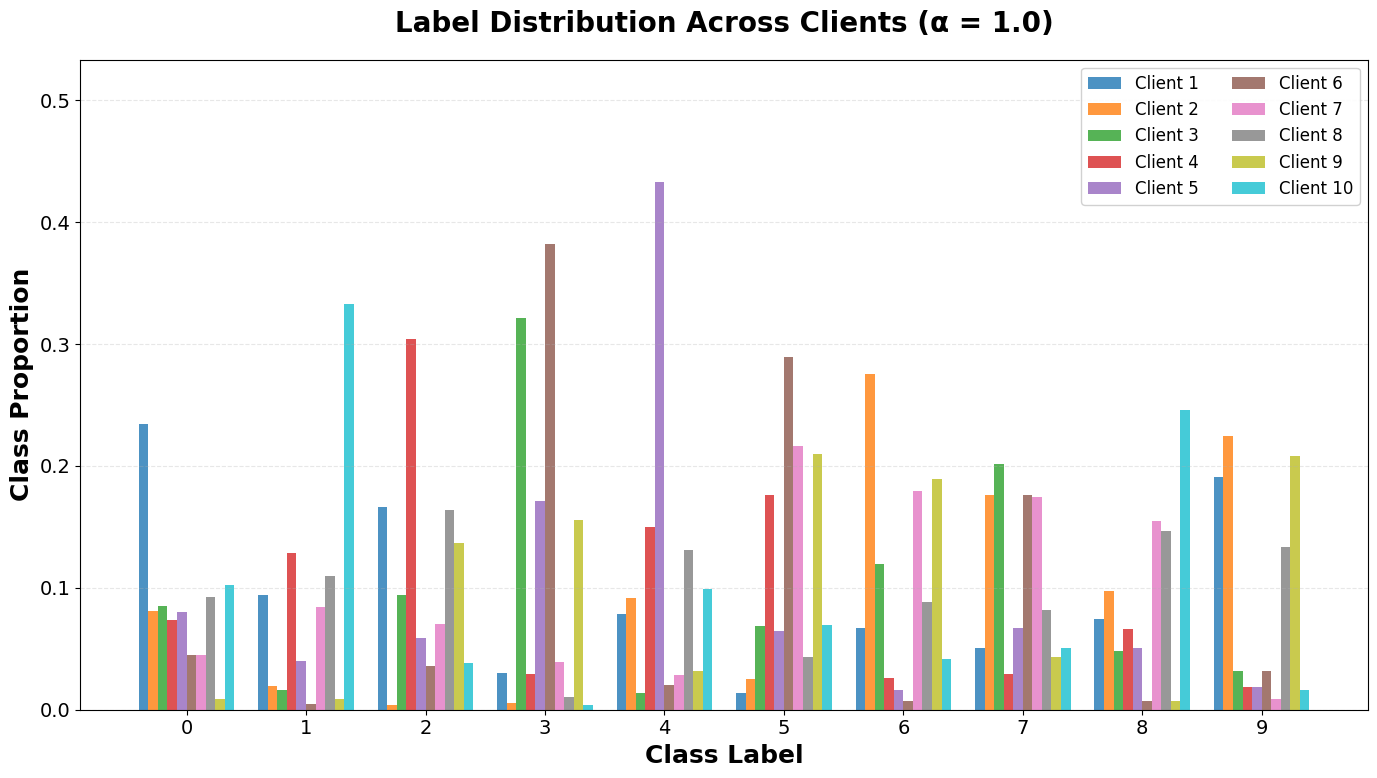

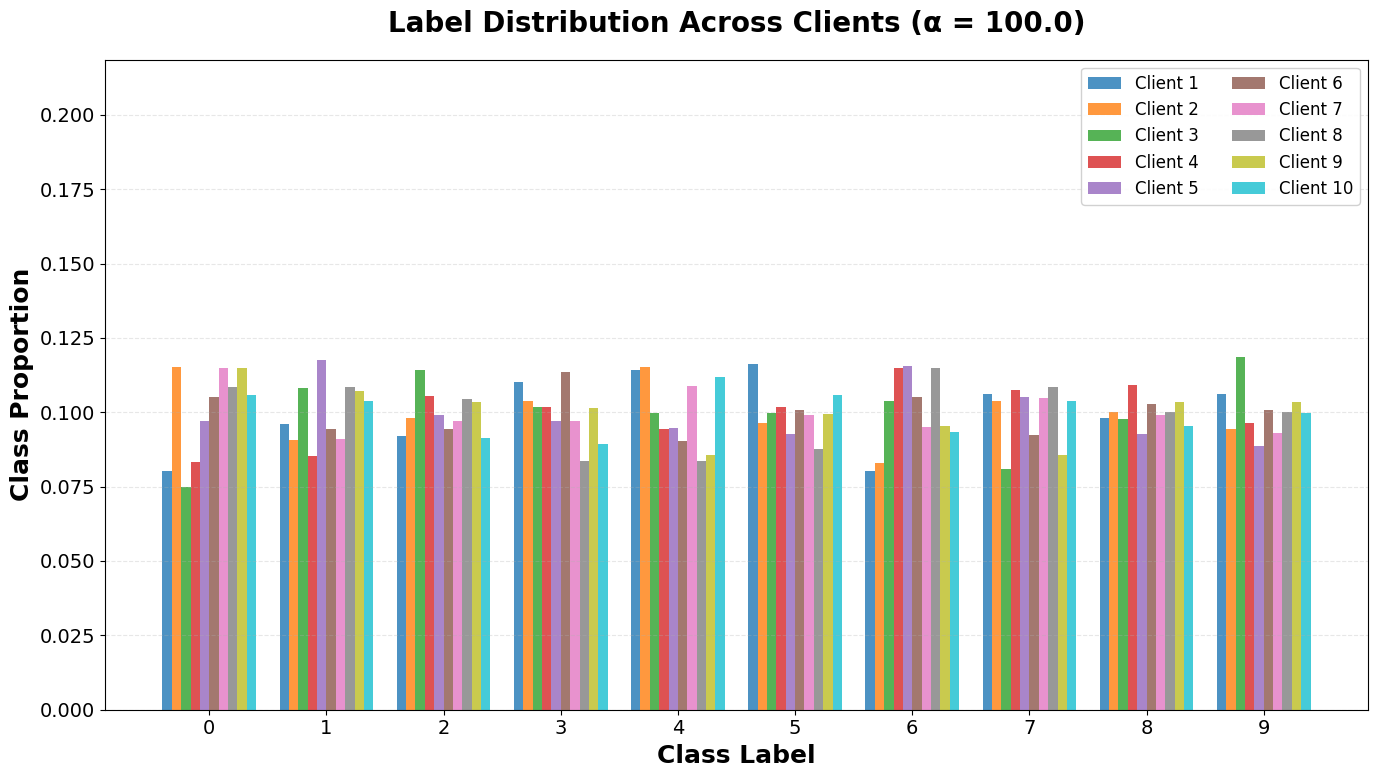

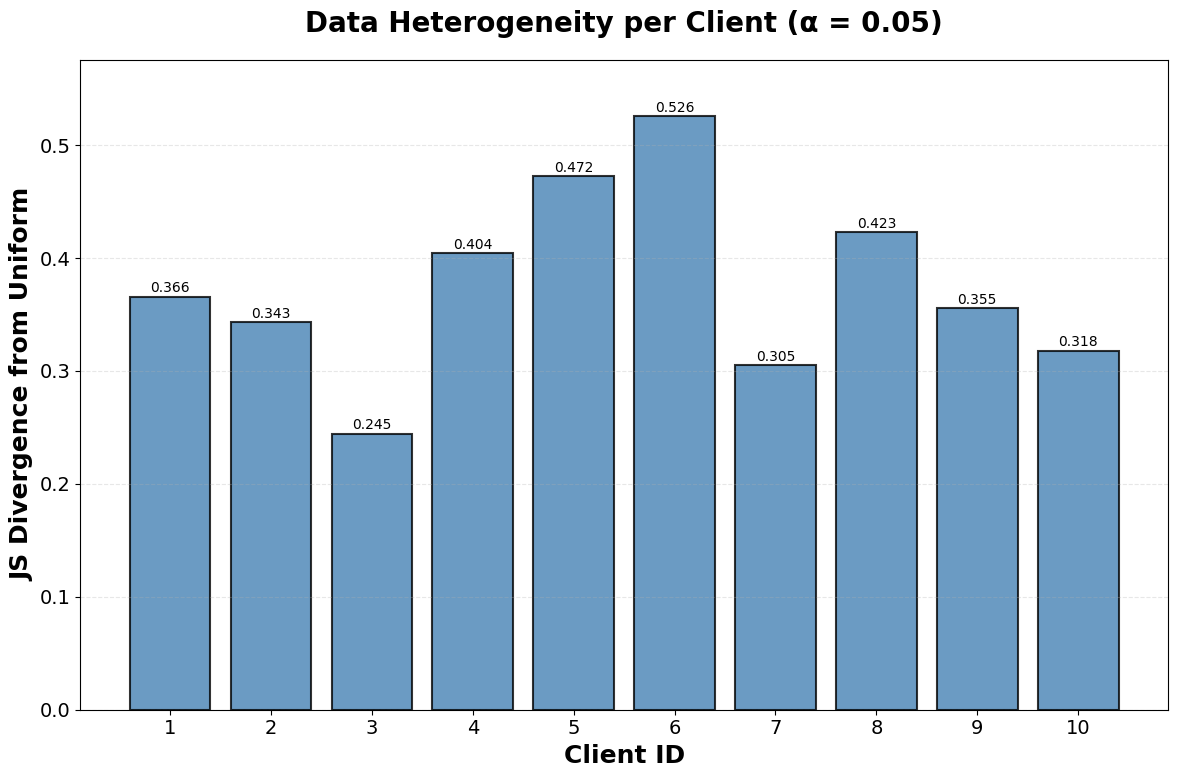

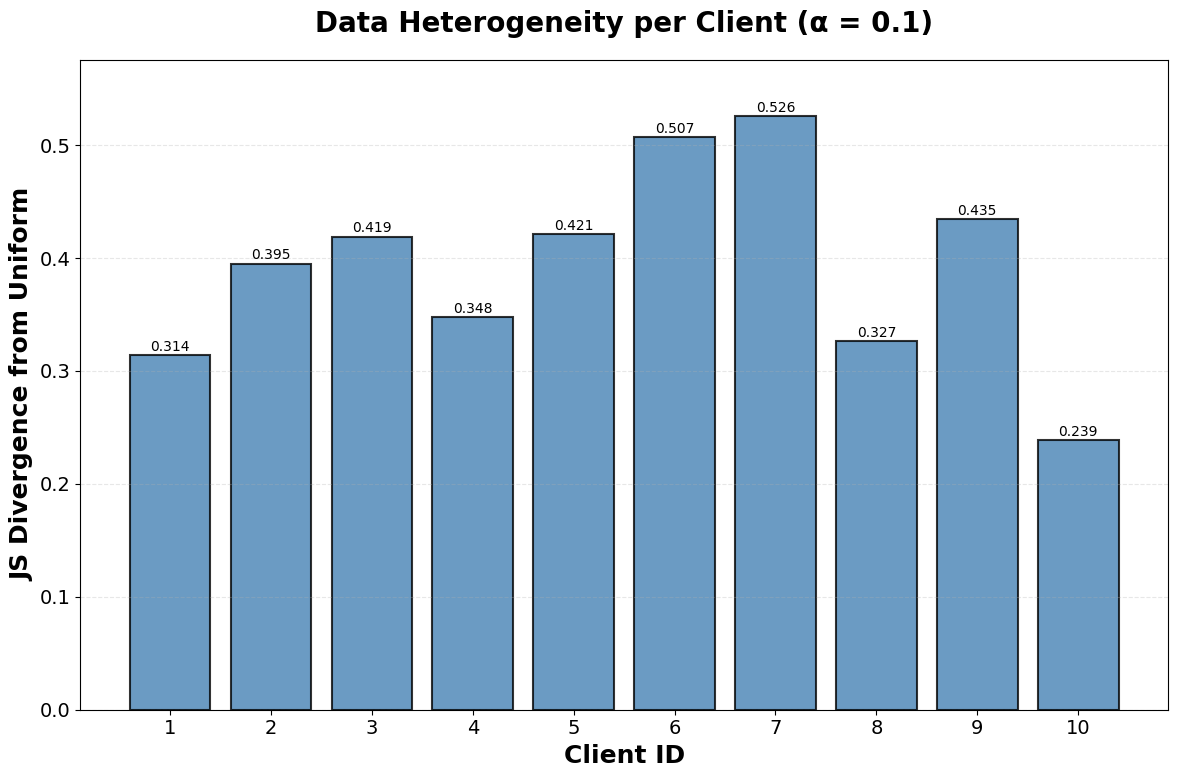

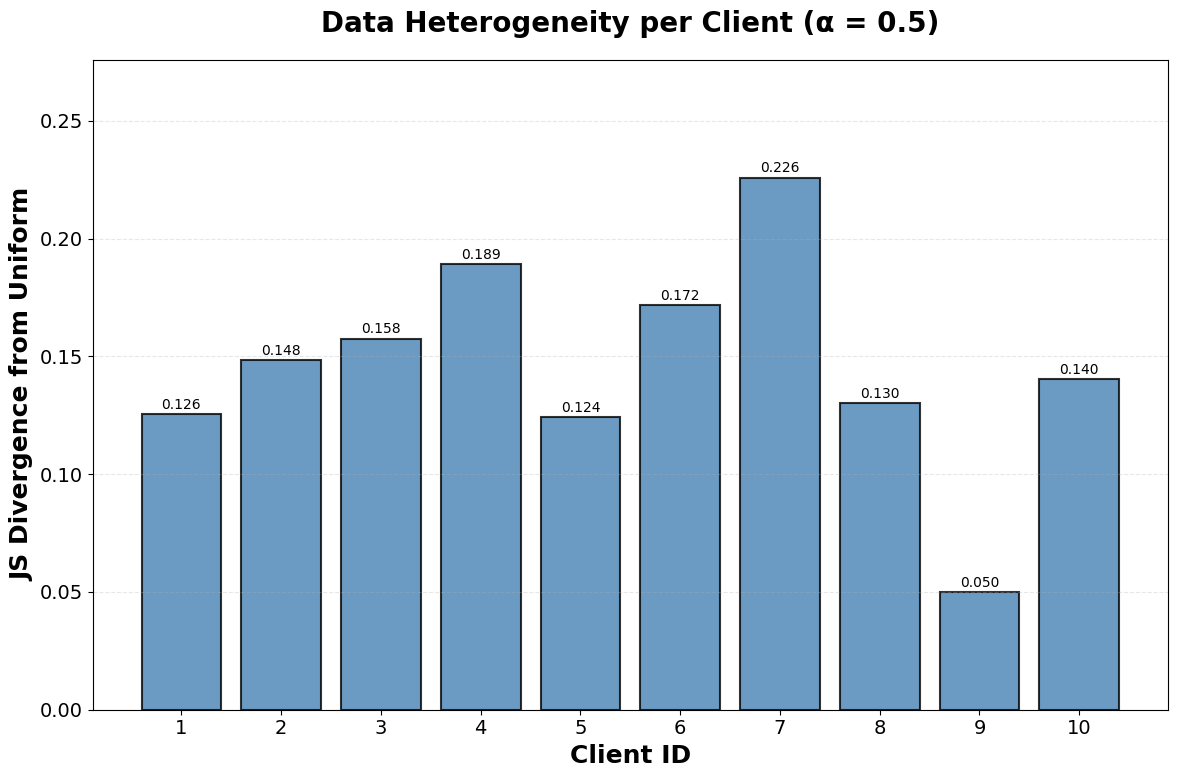

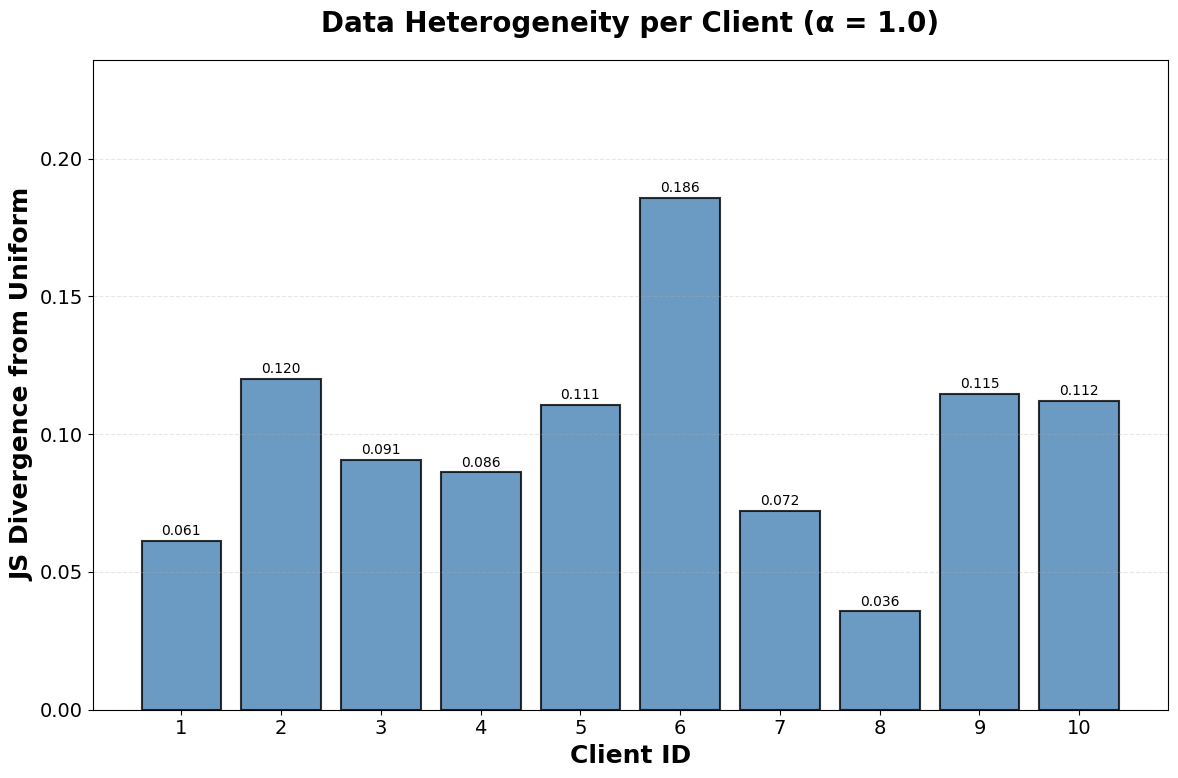

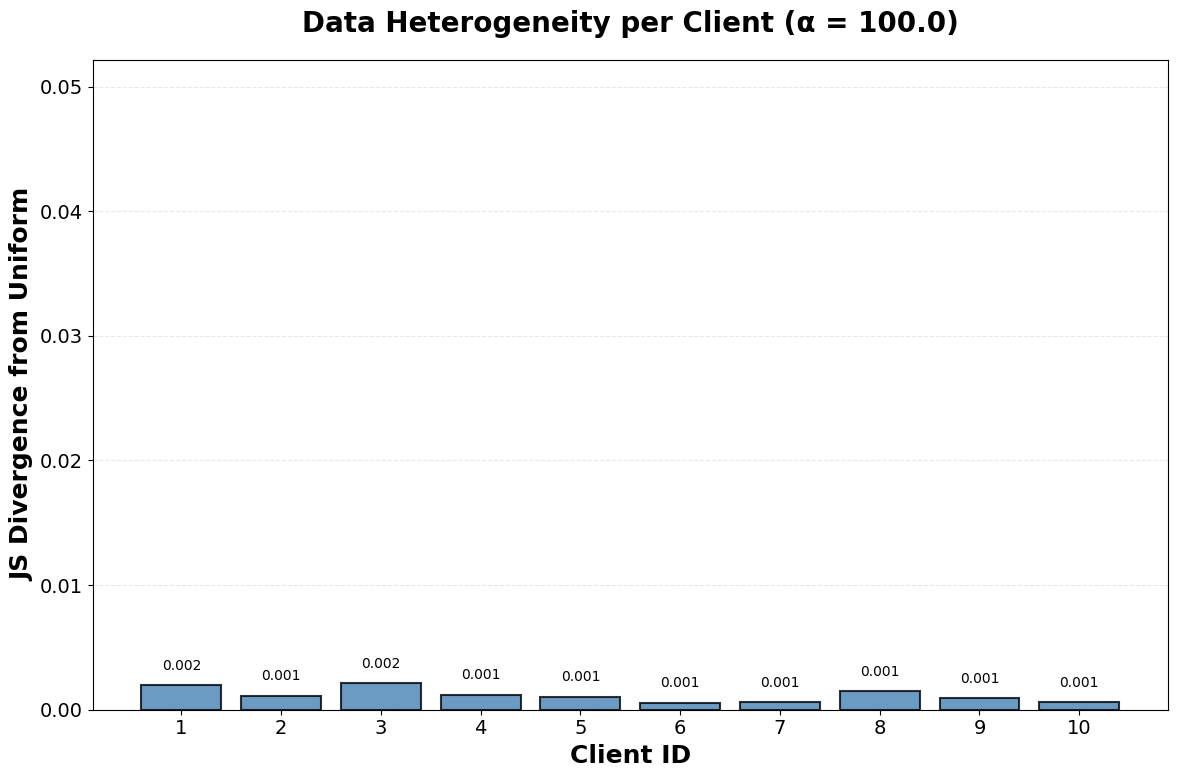

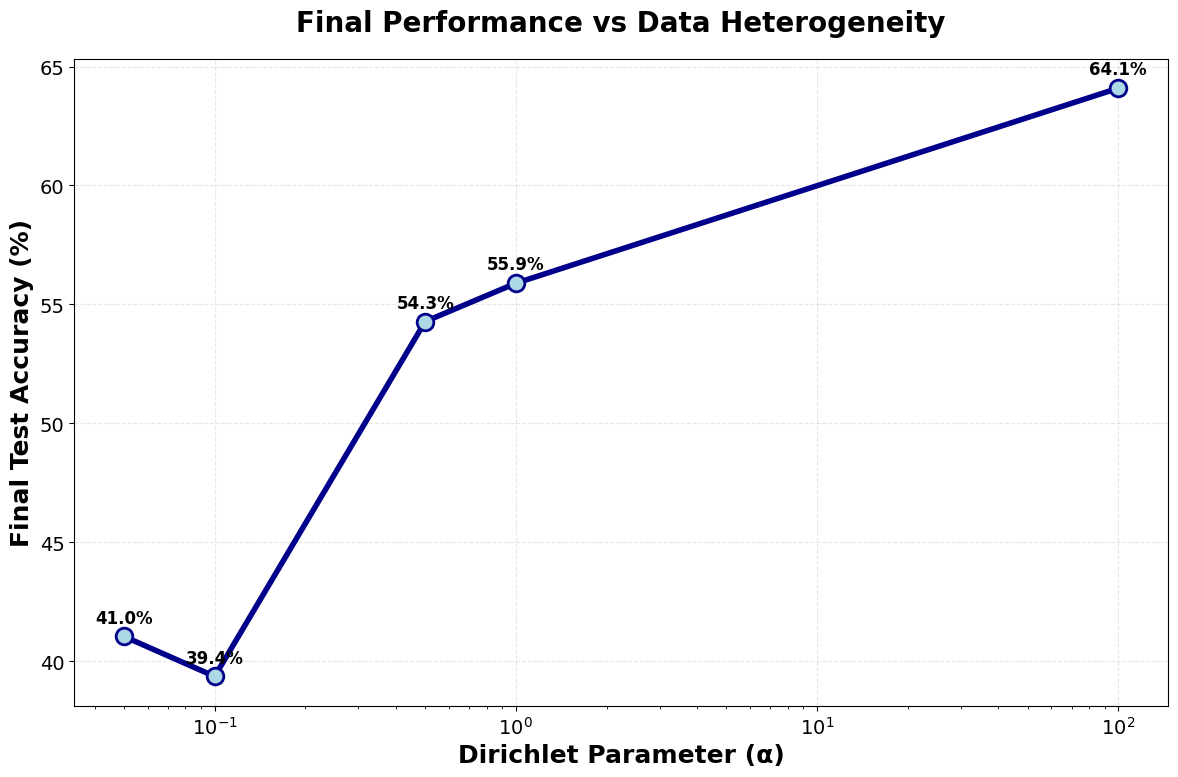

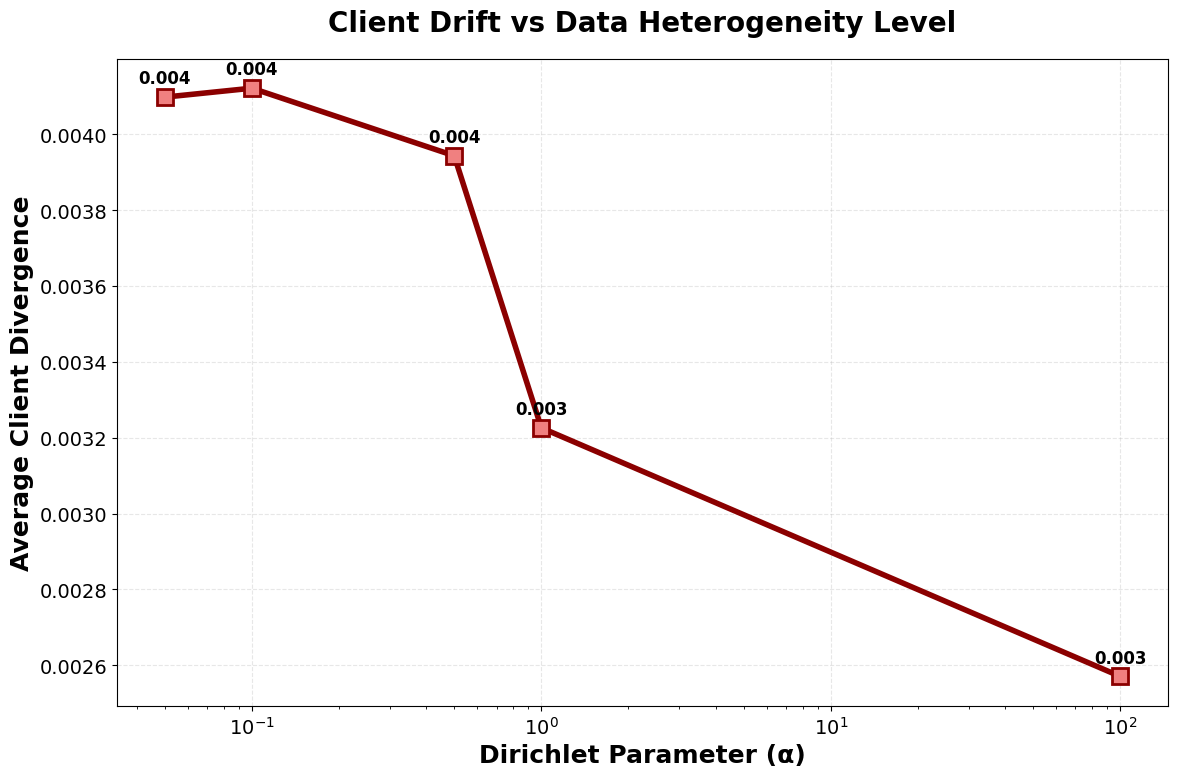

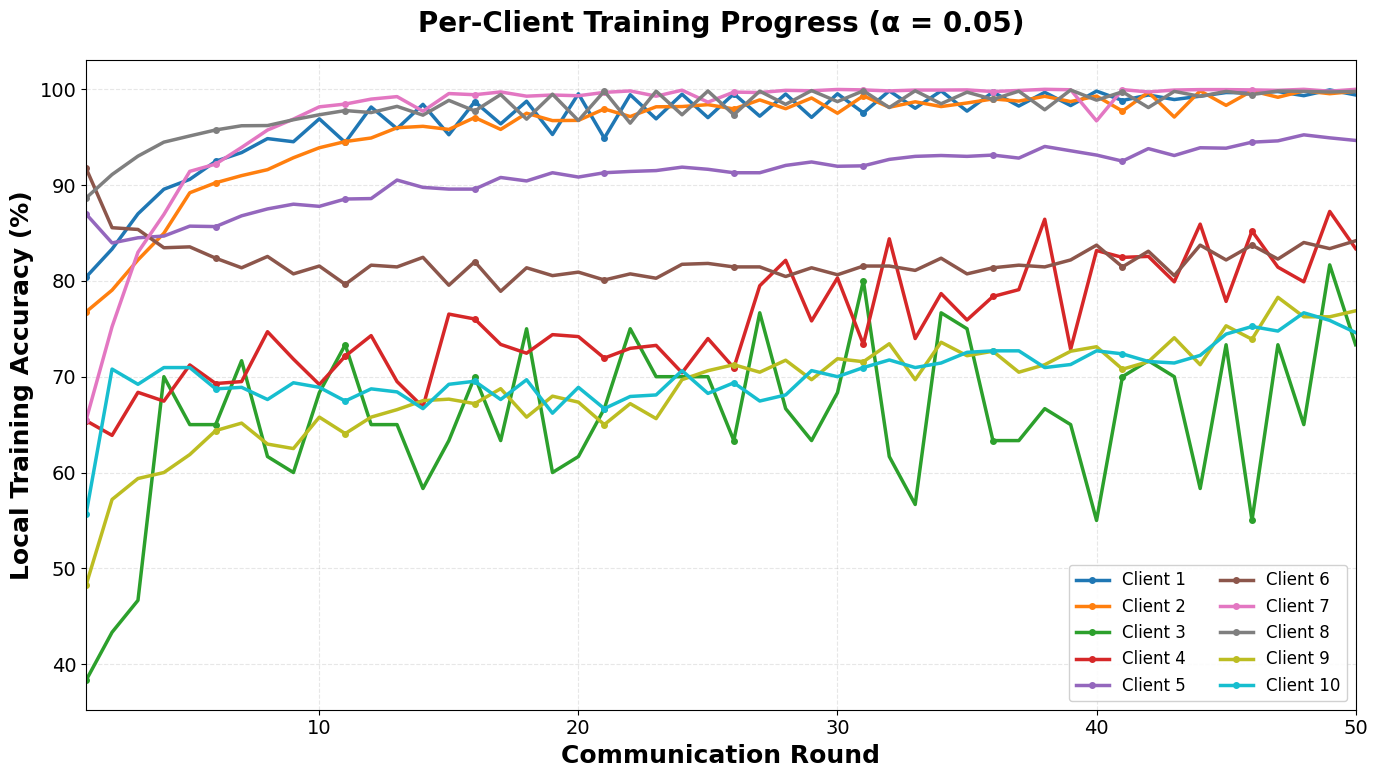


FINAL RESULTS SUMMARY

α =   0.05:
  Final Test Accuracy:       41.04%
  Final Test Loss:           1.7066
  Avg Client Divergence:     0.0041
  Final Generalization Gap:  47.55%

α =   0.10:
  Final Test Accuracy:       39.36%
  Final Test Loss:           1.7794
  Avg Client Divergence:     0.0041
  Final Generalization Gap:  51.12%

α =   0.50:
  Final Test Accuracy:       54.28%
  Final Test Loss:           1.7496
  Avg Client Divergence:     0.0039
  Final Generalization Gap:  41.28%

α =   1.00:
  Final Test Accuracy:       55.89%
  Final Test Loss:           1.7537
  Avg Client Divergence:     0.0032
  Final Generalization Gap:  42.34%

α = 100.00:
  Final Test Accuracy:       64.09%
  Final Test Loss:           1.3970
  Avg Client Divergence:     0.0026
  Final Generalization Gap:  35.87%


In [3]:

# === Fixed and improved visualizations ===
# Set global plot parameters
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8)})

# Only plot alphas that completed successfully
successful_alphas = list(all_results.keys())
print(f"Successfully trained alphas: {successful_alphas}")

# 1. Test Accuracy Comparison
if successful_alphas:
    plt.figure(figsize=(12, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, alpha in enumerate(successful_alphas):
        rounds = range(1, num_rounds + 1)
        plt.plot(rounds, all_results[alpha]['test_accuracy'],
                linewidth=3, marker='o', markersize=6, markevery=5,
                label=f'α = {alpha}', color=colors[i % len(colors)])

    plt.xlabel('Communication Round', fontsize=18, fontweight='bold')
    plt.ylabel('Test Accuracy (%)', fontsize=18, fontweight='bold')
    plt.title('Global Model Performance vs Data Heterogeneity', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=16, loc='lower right', framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim(1, num_rounds)
    plt.ylim(0, max([max(all_results[alpha]['test_accuracy']) for alpha in successful_alphas]) + 5)
    plt.tight_layout()
    plt.savefig('test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. Test Loss Comparison
if successful_alphas:
    plt.figure(figsize=(12, 8))

    for i, alpha in enumerate(successful_alphas):
        rounds = range(1, num_rounds + 1)
        plt.plot(rounds, all_results[alpha]['test_loss'],
                linewidth=3, marker='s', markersize=6, markevery=5,
                label=f'α = {alpha}', color=colors[i % len(colors)])

    plt.xlabel('Communication Round', fontsize=18, fontweight='bold')
    plt.ylabel('Test Loss', fontsize=18, fontweight='bold')
    plt.title('Global Model Loss vs Data Heterogeneity', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=16, loc='upper right', framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim(1, num_rounds)
    plt.tight_layout()
    plt.savefig('test_loss_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Client Divergence Comparison
if successful_alphas:
    plt.figure(figsize=(12, 8))

    for i, alpha in enumerate(successful_alphas):
        rounds = range(1, num_rounds + 1)
        plt.plot(rounds, all_results[alpha]['client_divergences'],
                linewidth=3, marker='^', markersize=6, markevery=5,
                label=f'α = {alpha}', color=colors[i % len(colors)])

    plt.xlabel('Communication Round', fontsize=18, fontweight='bold')
    plt.ylabel('Average Client Model Divergence', fontsize=18, fontweight='bold')
    plt.title('Client Drift vs Data Heterogeneity', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=16, loc='upper right', framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim(1, num_rounds)
    plt.tight_layout()
    plt.savefig('client_divergence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. Generalization Gap
if successful_alphas:
    plt.figure(figsize=(12, 8))

    for i, alpha in enumerate(successful_alphas):
        rounds = range(1, num_rounds + 1)
        generalization_gap = np.array(all_results[alpha]['train_accuracy']) - np.array(all_results[alpha]['test_accuracy'])
        plt.plot(rounds, generalization_gap,
                linewidth=3, marker='d', markersize=6, markevery=5,
                label=f'α = {alpha}', color=colors[i % len(colors)])

    plt.xlabel('Communication Round', fontsize=18, fontweight='bold')
    plt.ylabel('Generalization Gap (%)', fontsize=18, fontweight='bold')
    plt.title('Train-Test Gap vs Data Heterogeneity', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=16, loc='upper right', framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
    plt.xlim(1, num_rounds)
    plt.tight_layout()
    plt.savefig('generalization_gap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 5. Gradient Diversity
if successful_alphas:
    plt.figure(figsize=(12, 8))

    for i, alpha in enumerate(successful_alphas):
        rounds = range(1, num_rounds + 1)
        plt.plot(rounds, all_results[alpha]['gradient_diversity'],
                linewidth=3, marker='*', markersize=8, markevery=5,
                label=f'α = {alpha}', color=colors[i % len(colors)])

    plt.xlabel('Communication Round', fontsize=18, fontweight='bold')
    plt.ylabel('Pairwise Client Model Divergence', fontsize=18, fontweight='bold')
    plt.title('Gradient Diversity vs Data Heterogeneity', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=16, loc='upper right', framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim(1, num_rounds)
    plt.tight_layout()
    plt.savefig('gradient_diversity_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 6. Label Distribution for each alpha
for alpha in successful_alphas:
    distributions = all_distributions[alpha]
    plt.figure(figsize=(14, 8))

    x = np.arange(10)
    width = 0.08
    client_colors = plt.cm.tab10(np.linspace(0, 1, num_clients))

    for client_idx in range(num_clients):
        offset = width * (client_idx - num_clients / 2 + 0.5)
        plt.bar(x + offset, distributions[client_idx], width,
                label=f'Client {client_idx+1}', alpha=0.8,
                color=client_colors[client_idx])

    plt.xlabel('Class Label', fontsize=18, fontweight='bold')
    plt.ylabel('Class Proportion', fontsize=18, fontweight='bold')
    plt.title(f'Label Distribution Across Clients (α = {alpha})', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='upper right', framealpha=0.9, ncol=2)
    plt.xticks(x, [str(i) for i in range(10)])
    plt.grid(True, alpha=0.3, linestyle='--', axis='y')
    plt.ylim(0, max([max(distributions[i]) for i in range(num_clients)]) + 0.1)
    plt.tight_layout()
    plt.savefig(f'label_distribution_alpha_{alpha}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 7. JS Divergence for each alpha
uniform_dist = np.ones(10) / 10
for alpha in successful_alphas:
    distributions = all_distributions[alpha]
    plt.figure(figsize=(12, 8))

    js_divergences = []
    for client_idx in range(num_clients):
        js_div = compute_js_divergence(distributions[client_idx], uniform_dist)
        js_divergences.append(js_div)

    bars = plt.bar(range(1, num_clients + 1), js_divergences,
                   alpha=0.8, edgecolor='black', linewidth=1.5,
                   color='steelblue')

    # Add value labels on bars
    for bar, value in zip(bars, js_divergences):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Client ID', fontsize=18, fontweight='bold')
    plt.ylabel('JS Divergence from Uniform', fontsize=18, fontweight='bold')
    plt.title(f'Data Heterogeneity per Client (α = {alpha})', fontsize=20, fontweight='bold', pad=20)
    plt.xticks(range(1, num_clients + 1))
    plt.grid(True, alpha=0.3, linestyle='--', axis='y')
    plt.ylim(0, max(js_divergences) + 0.05)
    plt.tight_layout()
    plt.savefig(f'js_divergence_alpha_{alpha}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8. Final Performance vs Alpha
if successful_alphas:
    convergence_data = []
    for alpha in successful_alphas:
        final_acc = all_results[alpha]['test_accuracy'][-1]
        final_loss = all_results[alpha]['test_loss'][-1]
        avg_divergence = np.mean(all_results[alpha]['client_divergences'])
        convergence_data.append([alpha, final_acc, final_loss, avg_divergence])

    convergence_array = np.array(convergence_data)

    plt.figure(figsize=(12, 8))
    plt.plot(convergence_array[:, 0], convergence_array[:, 1],
            linewidth=4, marker='o', markersize=12, color='darkblue',
            markerfacecolor='lightblue', markeredgewidth=2, markeredgecolor='darkblue')

    # Add value labels
    for i, (x, y) in enumerate(zip(convergence_array[:, 0], convergence_array[:, 1])):
        plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=12, fontweight='bold')

    plt.xlabel('Dirichlet Parameter (α)', fontsize=18, fontweight='bold')
    plt.ylabel('Final Test Accuracy (%)', fontsize=18, fontweight='bold')
    plt.title('Final Performance vs Data Heterogeneity', fontsize=20, fontweight='bold', pad=20)
    plt.xscale('log')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('final_accuracy_vs_alpha.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(convergence_array[:, 0], convergence_array[:, 3],
            linewidth=4, marker='s', markersize=12, color='darkred',
            markerfacecolor='lightcoral', markeredgewidth=2, markeredgecolor='darkred')

    # Add value labels
    for i, (x, y) in enumerate(zip(convergence_array[:, 0], convergence_array[:, 3])):
        plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=12, fontweight='bold')

    plt.xlabel('Dirichlet Parameter (α)', fontsize=18, fontweight='bold')
    plt.ylabel('Average Client Divergence', fontsize=18, fontweight='bold')
    plt.title('Client Drift vs Data Heterogeneity Level', fontsize=20, fontweight='bold', pad=20)
    plt.xscale('log')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('average_divergence_vs_alpha.png', dpi=300, bbox_inches='tight')
    plt.show()

# 9. Per-Client Training Progress (for lowest alpha)
if successful_alphas:
    alpha = min(successful_alphas)  # Use the lowest available alpha
    plt.figure(figsize=(14, 8))
    client_colors = plt.cm.tab10(np.linspace(0, 1, num_clients))

    for client_idx in range(num_clients):
        rounds = range(1, num_rounds + 1)
        plt.plot(rounds, all_results[alpha]['client_train_acc'][client_idx],
                linewidth=2.5, marker='o', markersize=4, markevery=5,
                label=f'Client {client_idx+1}', color=client_colors[client_idx])

    plt.xlabel('Communication Round', fontsize=18, fontweight='bold')
    plt.ylabel('Local Training Accuracy (%)', fontsize=18, fontweight='bold')
    plt.title(f'Per-Client Training Progress (α = {alpha})', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='lower right', framealpha=0.9, ncol=2)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim(1, num_rounds)
    plt.tight_layout()
    plt.savefig(f'client_training_progress_alpha_{alpha}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 10. Final Results Summary
print('\n' + '='*80)
print('FINAL RESULTS SUMMARY')
print('='*80)
for alpha in successful_alphas:
    final_acc = all_results[alpha]['test_accuracy'][-1]
    final_loss = all_results[alpha]['test_loss'][-1]
    avg_div = np.mean(all_results[alpha]['client_divergences'])
    final_gap = all_results[alpha]['train_accuracy'][-1] - all_results[alpha]['test_accuracy'][-1]

    print(f'\nα = {alpha:6.2f}:')
    print(f'  Final Test Accuracy:       {final_acc:.2f}%')
    print(f'  Final Test Loss:           {final_loss:.4f}')
    print(f'  Avg Client Divergence:     {avg_div:.4f}')
    print(f'  Final Generalization Gap:  {final_gap:.2f}%')
print('='*80)